# First preliminary analysis of the proteomic data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import fastcluster
from sklearn.preprocessing import StandardScaler
import polars as pl


In [ ]:
## download the raw and the normalized signal data 

raw_data = pd.read_csv("./inputs/proteomics_data/raw_concentration.csv", sep=',')

## file of proteomic data with the normalized signal
norm_signal_prot = pd.read_csv("./inputs/proteomics_data/normalized_signal.csv", sep=',') 

In [4]:
print(raw_data.columns)

Index(['Metadata_plate_barcode', 'Metadata_well_id', 'Metadata_culture_time',
       'Metadata_compound_concentration', 'Metadata_Compound',
       'Metadata_cell_type', 'Metadata_cell_density', 'Metadata_plate_name',
       'Metadata_compound_concentration_unit', 'Metadata_nomic_sample_id',
       ...
       'P49767', 'O43915', 'P17948', 'P35968', 'Q9H7M9', 'Q9Y5W5', 'O95388',
       'P56704', 'P41221', 'P47992'],
      dtype='object', length=273)


In [ ]:
## our filtered file without the fully missing proteins
norm_signal= pd.read_csv("./inputs/proteomics_data/norm_signal_filtered.csv", sep=',')

norm_signal['Metadata_Plate']

0      BR00145683
1      BR00145683
2      BR00145683
3      BR00145683
4      BR00145683
          ...    
763    BR00145686
764    BR00145686
765    BR00145686
766    BR00145686
767    BR00145686
Name: Metadata_Plate, Length: 768, dtype: object

***Manuscript 1.2 and Figure S2 A and B***

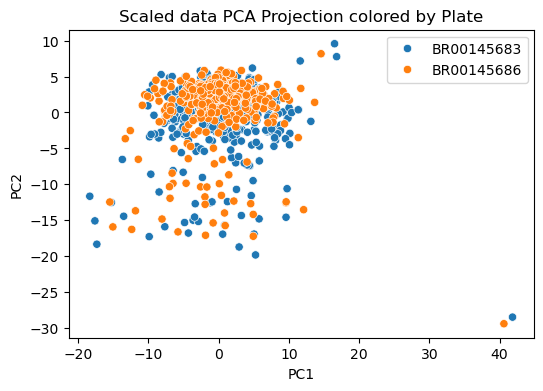

In [15]:
## scaled data PCA

scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA()
pca.fit(scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1


pca = PCA(n_components=n_components_99)
principal_components = pca.fit_transform(scaled)


column_names = [f'PC{i+1}' for i in range(n_components_99)]
pca_df = pd.DataFrame(data=principal_components, columns=column_names, index=norm_signal_filtered.index)


pca_df['Plate'] = norm_signal.loc[pca_df.index, 'Metadata_Plate']
pca_df['Compound'] = norm_signal.loc[pca_df.index, 'Metadata_Compound']
pca_df['Concentration'] = norm_signal.loc[pca_df.index, 'Metadata_Concentration']

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scaled data PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

['Untreated' 'Compound' 'DMSO']


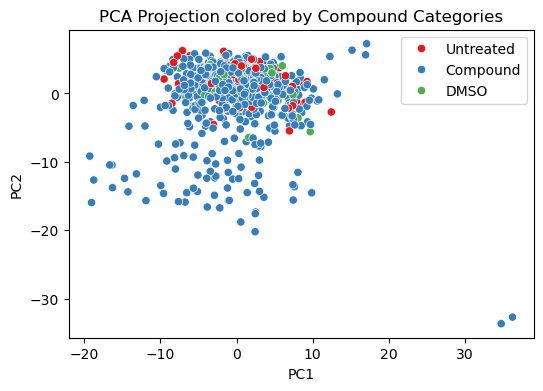

In [140]:
# scaled data PCA by compound categories

pca_df['Category'] = pca_df['Compound'].apply(
    lambda x: 'DMSO' if x == 'DMSO' else ('Untreated' if x == 'UNTREATED' else 'Compound')
)


print(pca_df['Category'].unique())

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Category'], palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Compound Categories")
plt.legend(bbox_to_anchor=(0.7, 1), loc='upper left')
plt.show()



***Section 1.2 and Figure 2B***

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter


pca_df['Concentration_safe'] = pca_df['Concentration'].replace(0, 0.001)


plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    c=pca_df['Concentration_safe'],
    norm=LogNorm(vmin=0.001, vmax=100),  # Échelle log !
    cmap="coolwarm",
    edgecolors='w',
    s=50
)

cbar = plt.colorbar(scatter, format=LogFormatter(10))
cbar.set_label('Concentration (log scale)')
cbar.set_ticks([0.001, 0.01, 0.1, 1, 10, 100])
cbar.set_ticklabels(["0.001", "0.01", "0.1", "1", "10", "100"])

# Axes
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Concentration")
plt.tight_layout()
plt.show()

## Pairwise Cosine Similarity 

***Section 2 / Figure 4***

In [ ]:
## loading imputed protein data without missing proteins

imputed_prot = pd.read_csv("./00.exploratory_analysis/inputs/proteomics_data/norm_signal_filtered.csv", sep=',')

from sklearn.metrics.pairwise import cosine_similarity

df_proteins = imputed_prot.loc[:, ~imputed_prot.columns.str.startswith("Metadata")]

df_transposed = df_proteins.T

cos_sim_matrix = cosine_similarity(df_transposed)


We compute pairwise cosine similarity between protein feature vectors to quantify their directional similarity.
A value close to 1 indicates that the proteins share similar feature profiles, suggesting potential functional or phenotypic resemblance.

In [ ]:
##  Clustered Pairwise Cosine Similarity between Proteins with protein names

bmd_df = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/bmd_pass_with_protein_name.csv", sep=",")
imputed_prot = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/inputs/proteomics_data/norm_signal_filtered.csv", sep=",")


imputed_filtered = imputed_prot

feature_cols = [col for col in imputed_filtered.columns if not col.startswith("Metadata")]
df_proteins = imputed_filtered[feature_cols]

df_transposed = df_proteins.T

id_to_protein = bmd_df.set_index('gene.id')['protein'].to_dict()

df_transposed.rename(index=id_to_protein, inplace=True)

protein_names = df_transposed.index
cos_sim_df = pd.DataFrame(cos_sim_matrix, index=protein_names, columns=protein_names)

g = sns.clustermap(
    cos_sim_df,
    cmap="coolwarm",
    figsize=(40, 40),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Cosine Similarity'},
)

g.ax_heatmap.tick_params(axis='x', labelsize=8)
g.ax_heatmap.tick_params(axis='y', labelsize=8)


#plt.suptitle("Clustered Pairwise Cosine Similarity between Proteins", y=1, fontsize=50)

g.savefig("./00.exploratory_analysis/figures/figure4D.png", dpi=300, bbox_inches='tight')
g.savefig("./00.exploratory_analysis/figures/figure4D.pdf", bbox_inches='tight')

plt.show()

We compute the pairwise cosine similarity between compounds by averaging the protein feature vectors across all replicates and concentrations for each compound. Then, we visualize the similarities using a clustered heatmap to highlight patterns of compound similarity.

In [32]:

feature_cols = [col for col in imputed_prot.columns if not col.startswith("Metadata")]

compounds = imputed_prot["Metadata_Compound"].unique()

compound_vectors = {}
for comp in compounds:
    comp_data = imputed_prot[imputed_prot["Metadata_Compound"] == comp][feature_cols].values
    compound_vectors[comp] = comp_data.mean(axis=0)

dmso_vec = compound_vectors["DMSO"]
compound_vectors.pop("DMSO")
compound_vectors.pop("UNTREATED")

norm_vec = {}
compounds = list(compound_vectors.keys())
for comp in compounds:
    comp_data = compound_vectors[comp]
    norm_vec[comp] = comp_data - dmso_vec


compound_names = list(norm_vec.keys())
vectors = [norm_vec[name] for name in compound_names]

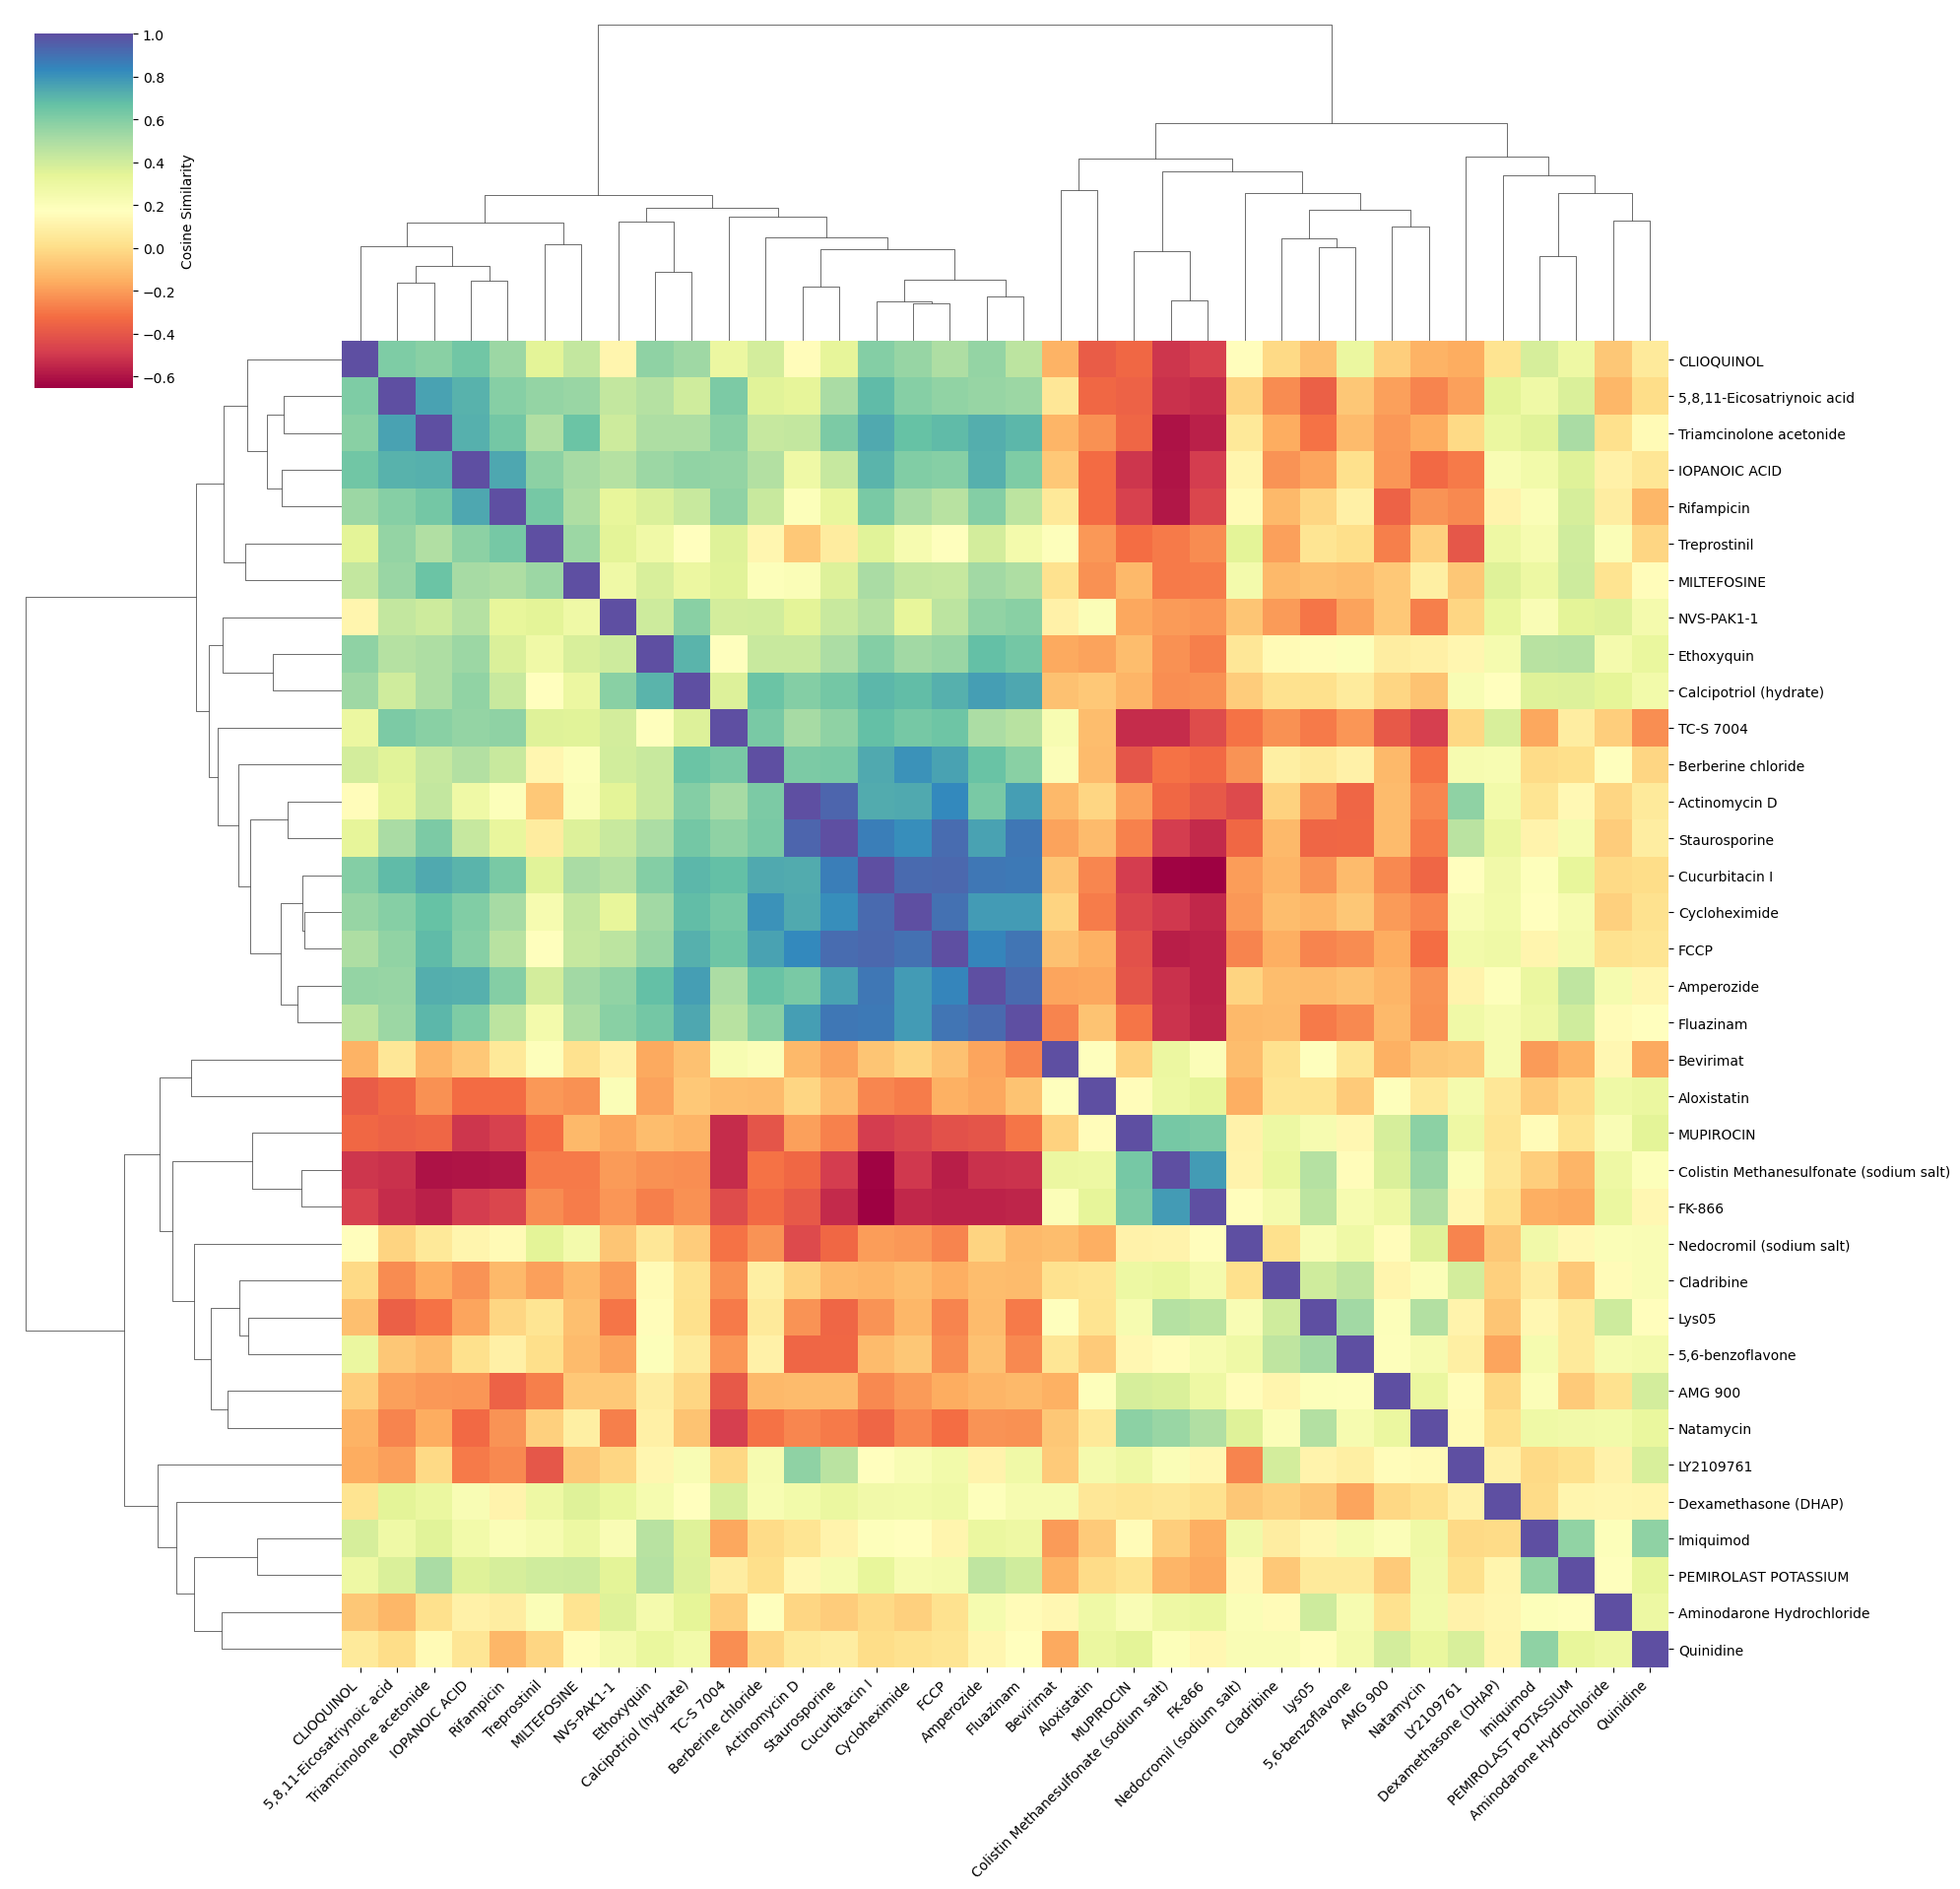

In [34]:

similarity_matrix = cosine_similarity(vectors)


sim_df = pd.DataFrame(similarity_matrix, index=compound_names, columns=compound_names)

g = sns.clustermap(
    sim_df,
    cmap="Spectral",
    figsize=(20, 20),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Cosine Similarity'}
)

# Rotation des labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

g.savefig("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/figures/figure4B.png", dpi=300, bbox_inches='tight')
g.savefig("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/figures/figure4B.pdf", bbox_inches='tight')


plt.show()

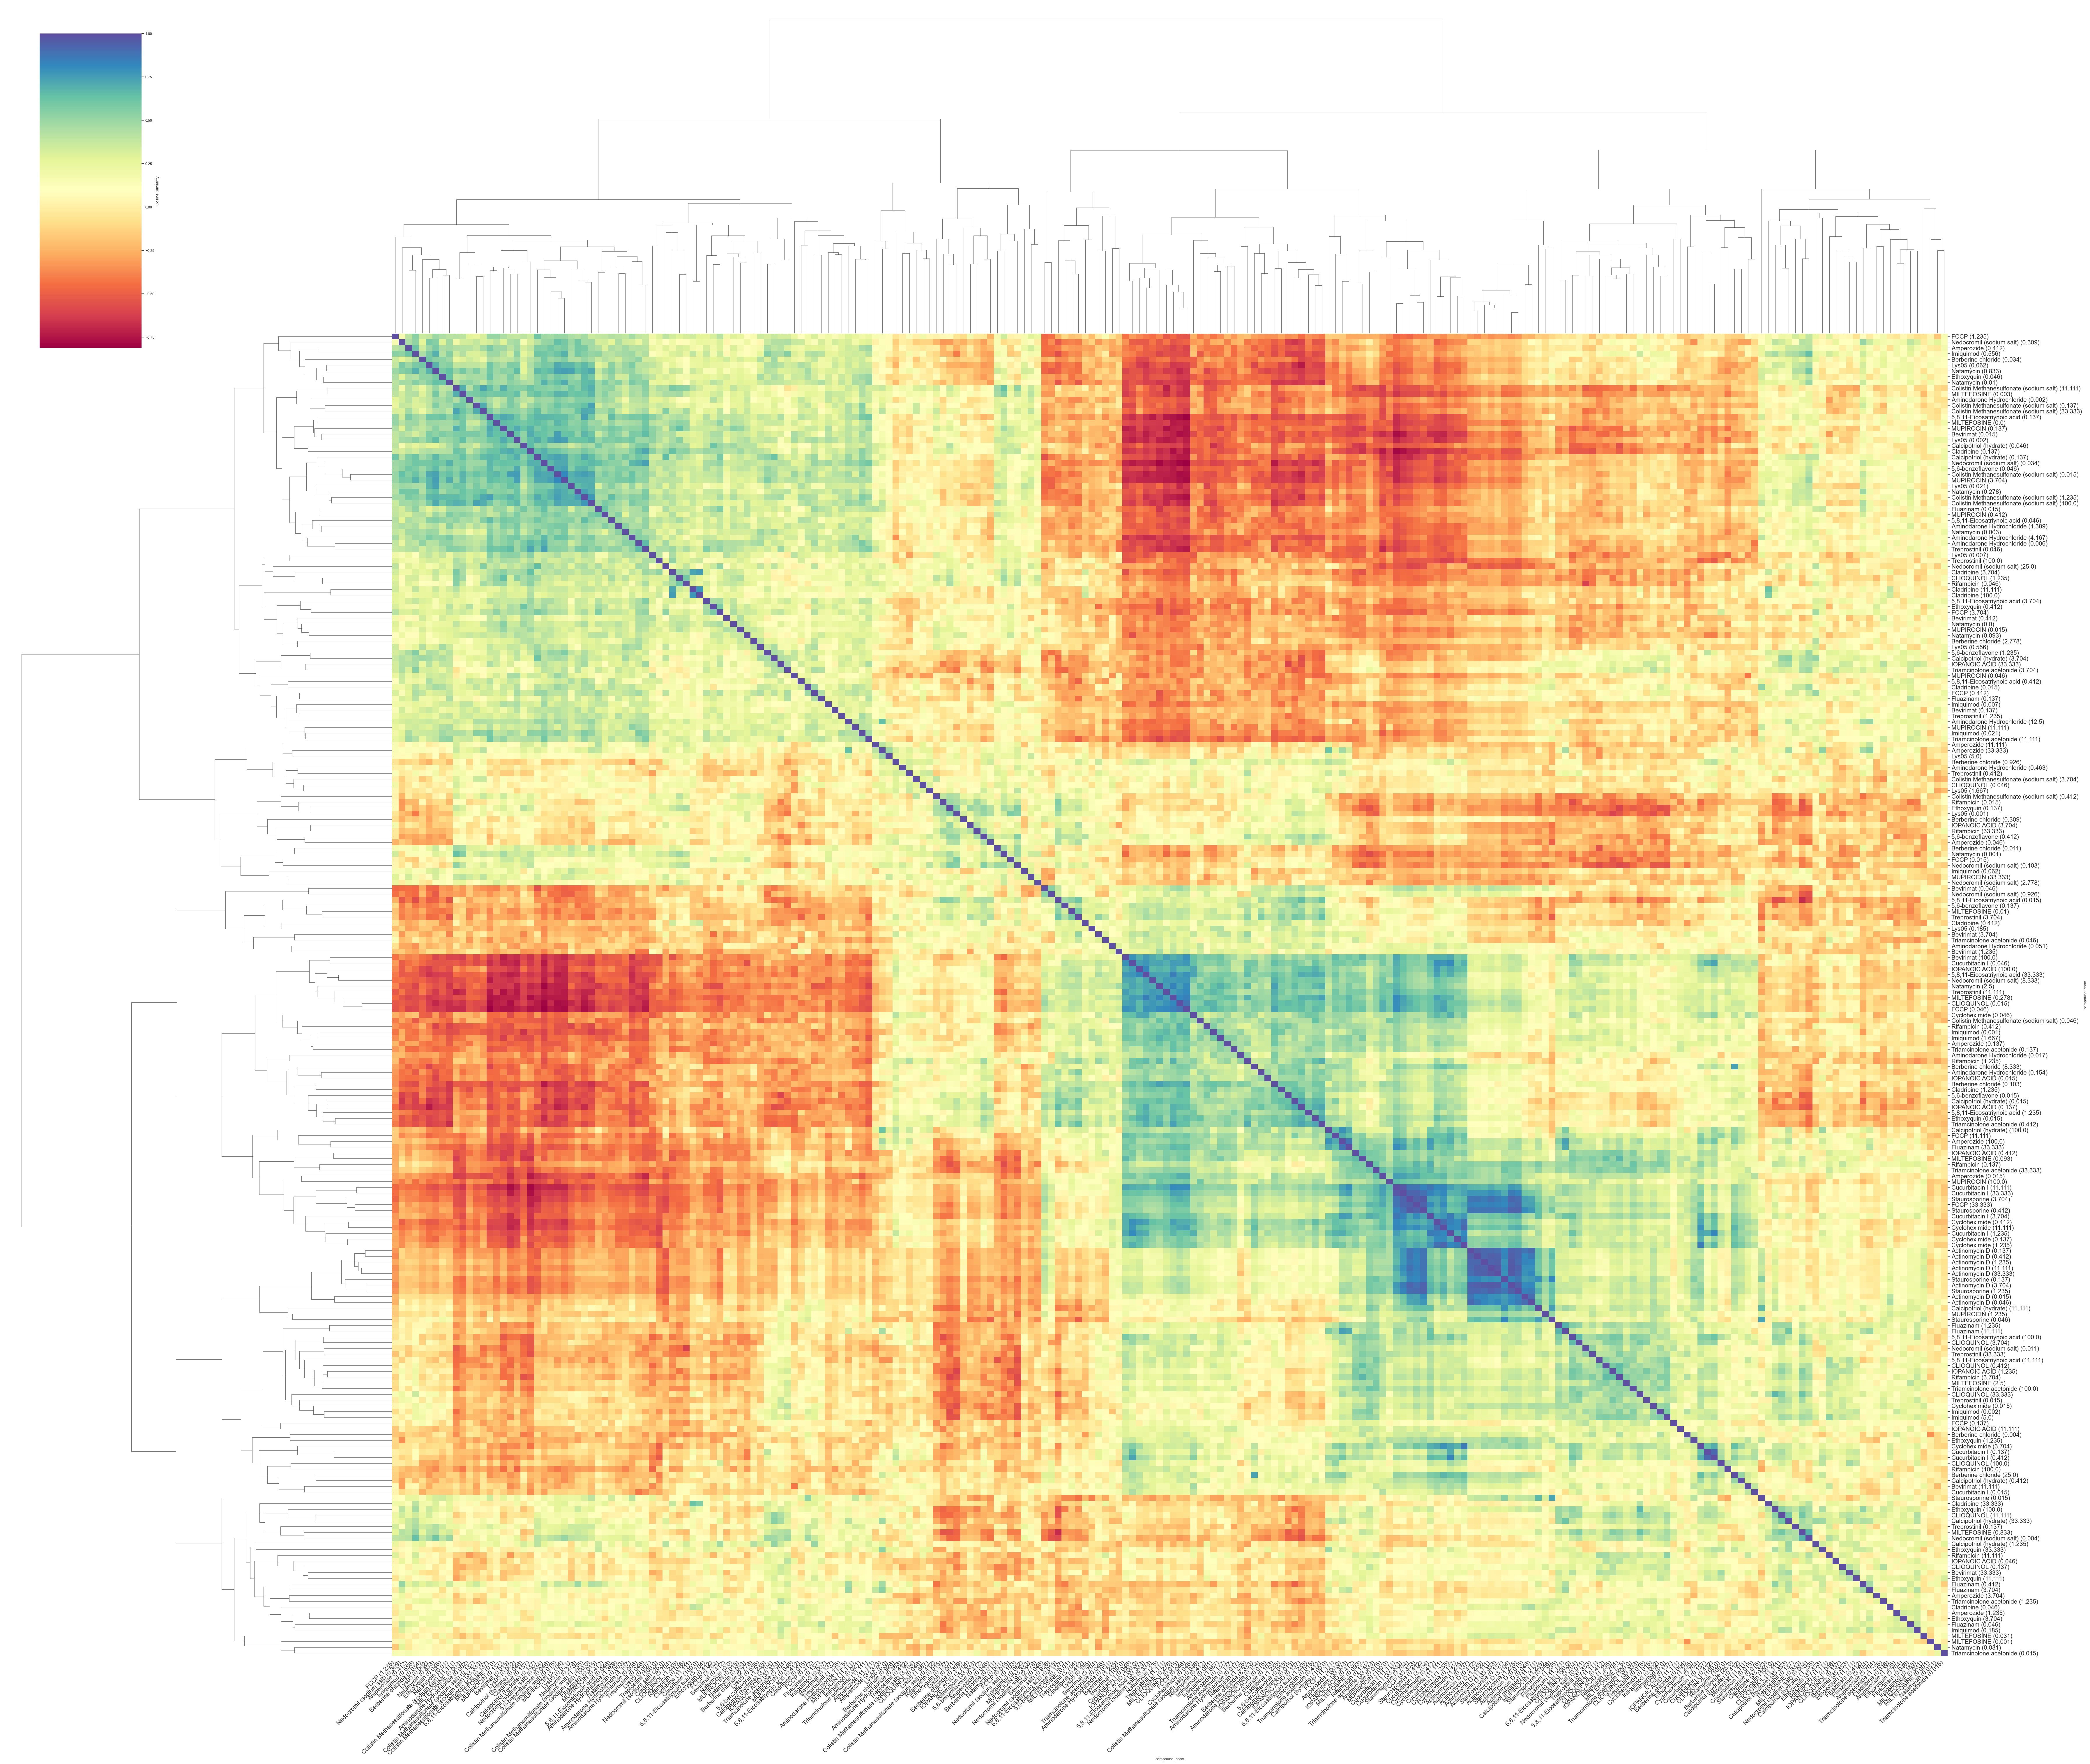

<Figure size 640x480 with 0 Axes>

In [ ]:
## clustered heatmap of compounds per concentration <= mean bmd


mean_conc_data = pd.read_csv(
    "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/proteomic_bmd_dose_results_mean_conc.csv",
    sep=";"
)

merged_df = imputed_prot.merge(
    mean_conc_data[['compound', 'mean_concentration']],
    left_on='Metadata_Compound',
    right_on='compound',
    how='left'
)

filtered_df = merged_df[
    merged_df['Metadata_Concentration'] <= merged_df['mean_concentration']
]

protein_cols = [col for col in filtered_df.columns if col.startswith("O") or col.startswith("P") or col.startswith("Q")]

grouped_profiles = (
    filtered_df
    .groupby(["Metadata_Compound", "Metadata_Concentration"])[protein_cols]
    .mean()
    .reset_index()
)

grouped_profiles["compound_conc"] = grouped_profiles["Metadata_Compound"] + " (" + grouped_profiles["Metadata_Concentration"].round(3).astype(str) + ")"

dmso_rows = imputed_prot[imputed_prot["Metadata_Compound"] == "DMSO"]
non_dmso_profiles = grouped_profiles[~grouped_profiles["Metadata_Compound"].isin(["DMSO", "UNTREATED"])]

dmso_mean_vec = dmso_rows[protein_cols].mean().values

normalized_profiles = non_dmso_profiles.copy()
normalized_profiles[protein_cols] = normalized_profiles[protein_cols].subtract(dmso_mean_vec, axis=1)

similarity_matrix = pd.DataFrame(
    cosine_similarity(normalized_profiles[protein_cols]),
    index=normalized_profiles["compound_conc"],
    columns=normalized_profiles["compound_conc"]
)

sns.set(font_scale=0.8)
g = sns.clustermap(
    similarity_matrix,
    cmap="Spectral",
    figsize=(70,60),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Cosine Similarity'}
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

g.ax_heatmap.tick_params(axis='x', labelsize=15)
g.ax_heatmap.tick_params(axis='y', labelsize=15)


#plt.suptitle("Clustered Pairwise Cosine Similarity between Proteins", y=1, fontsize=50)

g.savefig("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/figures/figure4C.png", dpi=300, bbox_inches='tight')
g.savefig("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/figures/figure4C.pdf", bbox_inches='tight')


#plt.suptitle("Clustered Cosine Similarity of Compound per Concentration", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


# Fold changes

***Figure 4A***

In [3]:

filt_dat = pl.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/inputs/proteomics_data/norm_signal_filtered.csv").filter(
    pl.col("Metadata_Categories") != "JUMP Control"
)

prot_keep = [i for i in filt_dat.columns if "Metadata" not in i]
cmpd_keep = filt_dat.select("Metadata_Compound").to_series().unique().to_list()

prot_dat = pl.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/inputs/proteomics_data/imputed_concentration.csv").filter(
    pl.col("Metadata_Compound") != "UNTREATED"
).filter(
    pl.col("Metadata_Compound").is_in(cmpd_keep)
)
feat_cols = [i for i in prot_dat.columns if "Metadata" not in i]

dat = prot_dat.unpivot(
    index=["Metadata_Compound", "Metadata_compound_concentration"],
    on=feat_cols,
    variable_name="Uniprot",
    value_name="Signal"
).filter(
    pl.col("Uniprot").is_in(prot_keep)
)

# Calculate mean concentration across replicates
dat = dat.group_by(["Metadata_Compound", "Metadata_compound_concentration", "Uniprot"]).agg([
    pl.mean("Signal")
])

# Add a column with DMSO conc for that protein
dat_dmso = dat.filter(pl.col("Metadata_Compound") == "DMSO").select(["Uniprot", "Signal"]).rename({"Signal": "DMSO_Uniprot_Signal"})
dat = dat.filter(pl.col("Metadata_Compound") != "DMSO").join(dat_dmso, on="Uniprot")

# calculate the log2FC
dat = dat.with_columns(
    (pl.col("Signal")/pl.col("DMSO_Uniprot_Signal")).alias("ratio"),
).with_columns(
    pl.col("ratio").log(base=2).alias("log2fc")
)

In [4]:
# calculate the max fold-change per compound
max_fc_long = (
    dat.with_columns([
        pl.col("log2fc").abs().alias("abs_log2fc")
    ])
    .sort("abs_log2fc", descending=True)
    .group_by(["Metadata_Compound", "Uniprot"])
    .agg([
        pl.col("log2fc").first().alias("max_fc")
    ])
)

max_fc = max_fc_long.pivot(
    index="Metadata_Compound",
    on="Uniprot",
    values="max_fc"
)

/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_2369/1493730057.py:6: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


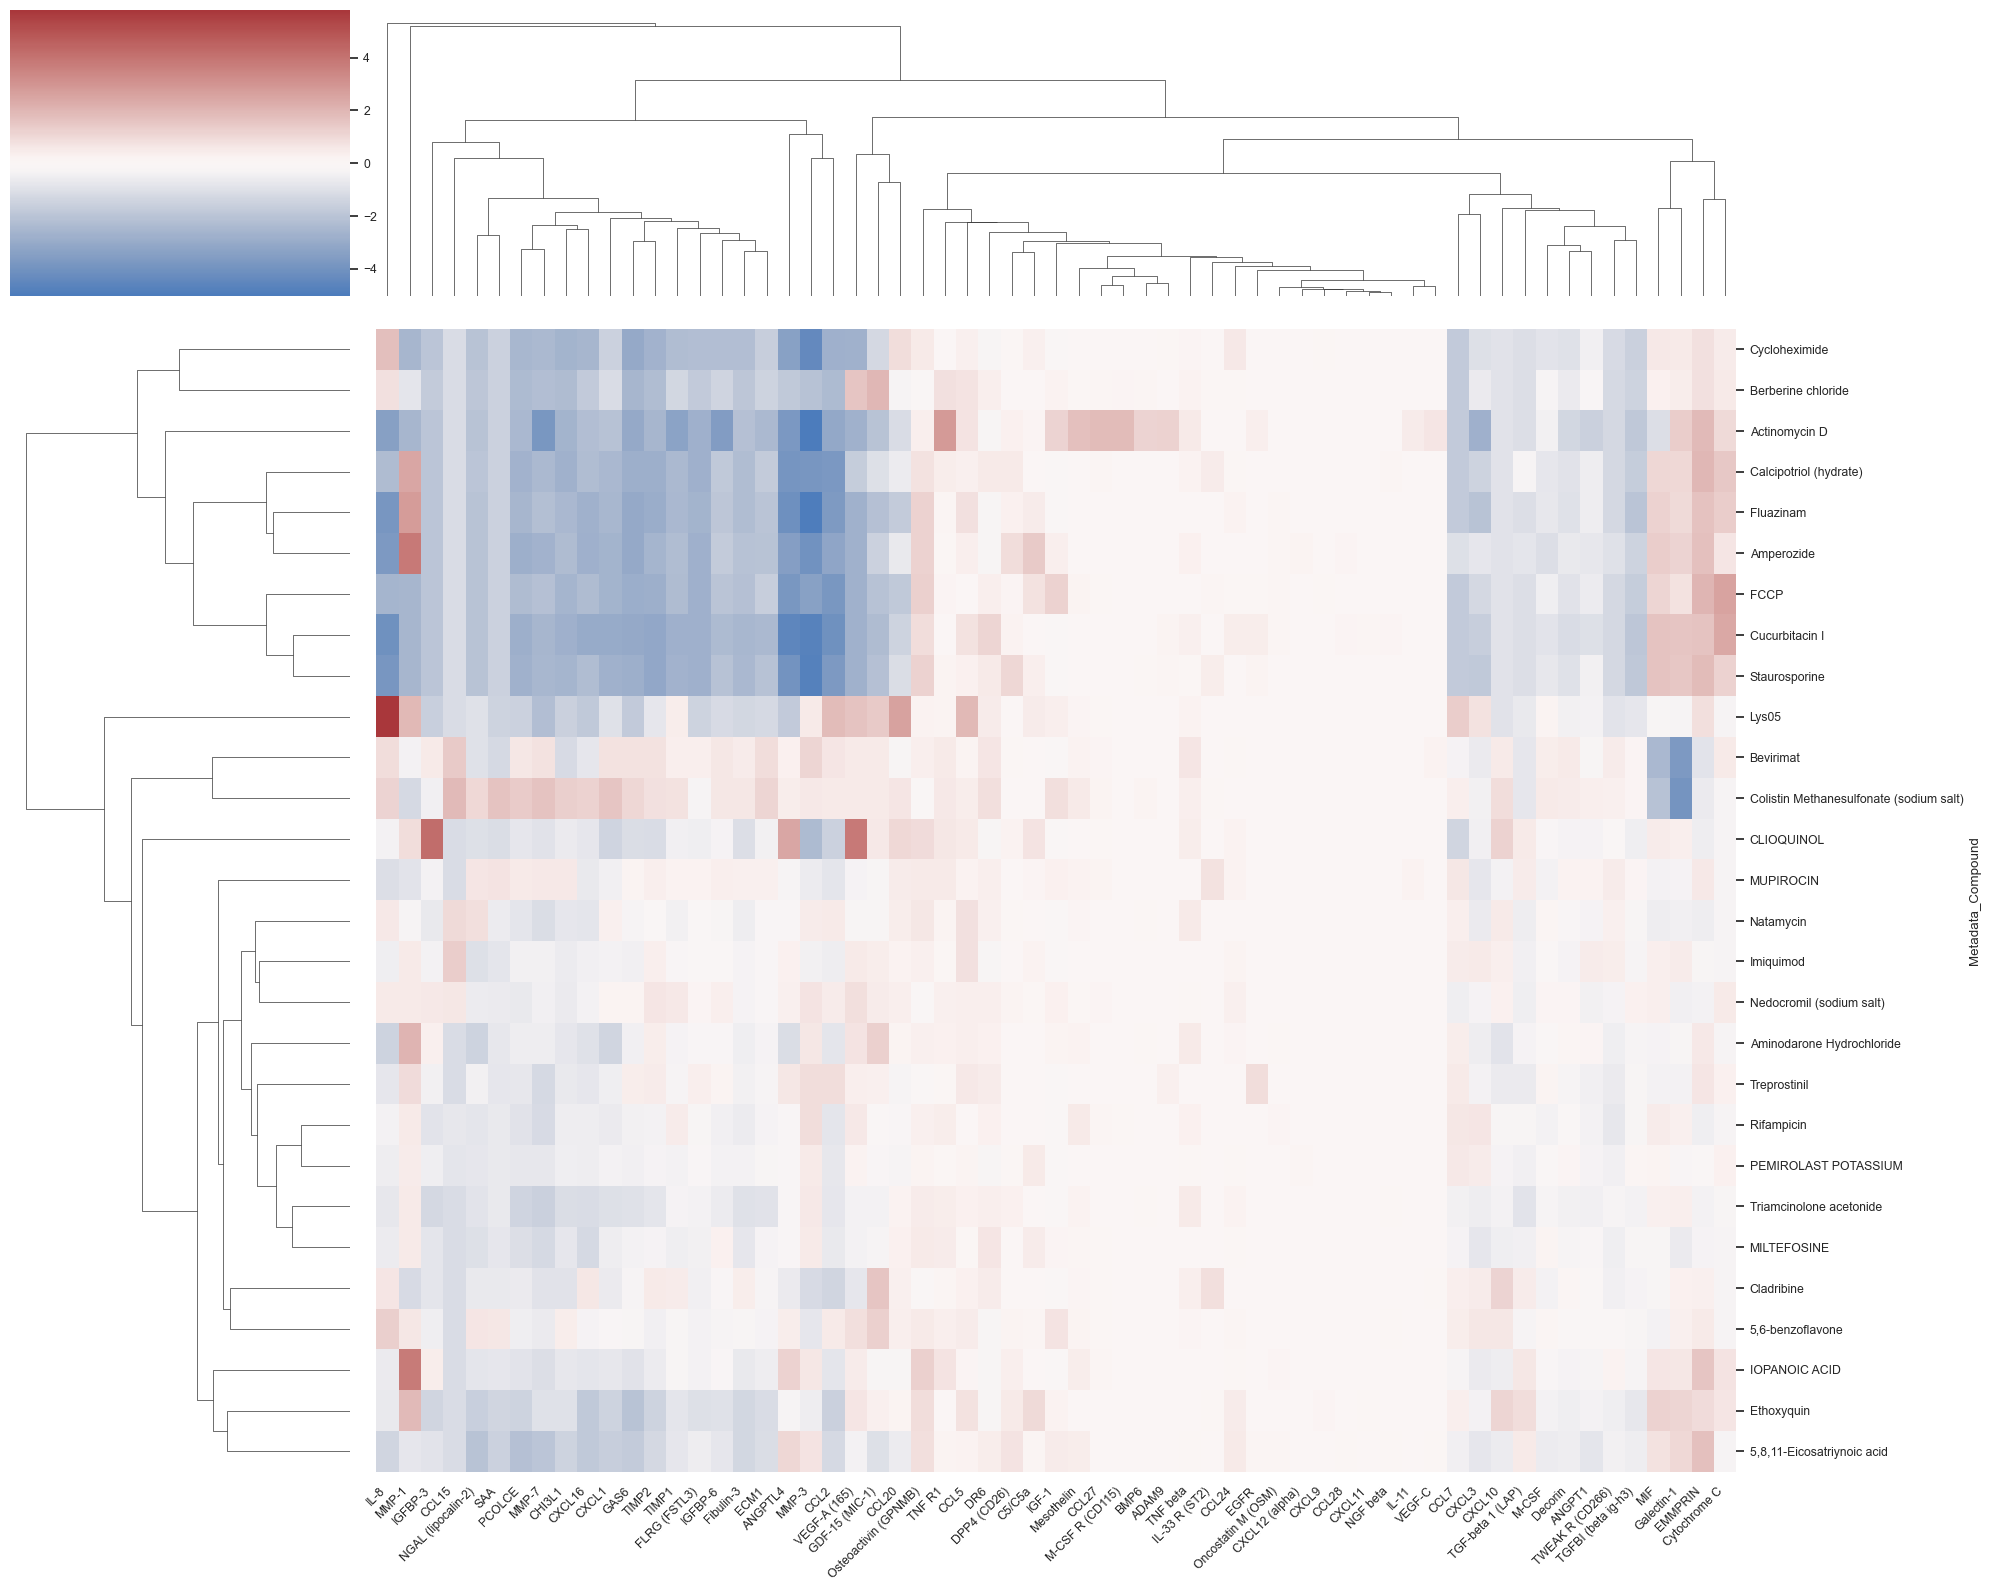

In [6]:
bmd_res = pl.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/bmd_pass_with_protein_name.csv")

prot_count = (
    bmd_res
    .group_by("gene.id")
    .count()
    .sort("count", descending=True)
).filter(pl.col("count") > 2)

bmd_prot = prot_count.select("gene.id").to_series().unique().to_list()

gene_to_protein = (
    bmd_res
    .filter(pl.col("gene.id").is_in(bmd_prot))
    .unique(subset=["gene.id"])  
    .select(["gene.id", "protein"])
    .to_pandas()
    .set_index("gene.id")["protein"]
    .to_dict()
)

df = max_fc_long.filter(pl.col("Uniprot").is_in(bmd_prot)).pivot(
    index="Metadata_Compound",
    on="Uniprot",
    values="max_fc"
).to_pandas()

df = df.set_index("Metadata_Compound")
df = df.rename(columns=gene_to_protein)

sns.set(font_scale=0.8)
g = sns.clustermap(
    df,
    cmap="vlag",
    center=0, 
    figsize=(20, 16),
    xticklabels=True,
    yticklabels=True,
    metric="euclidean",
    method="average",
)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right")

g.savefig("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/figures/figure4A.png", dpi=300, bbox_inches='tight')
g.savefig("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/figures/figure4A.pdf", bbox_inches='tight')


#plt.suptitle("Clustered Cosine Similarity of Compound per Concentration", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()
